In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import mlflow
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

import mlflow
import mlflow.sklearn
import mlflow.lightgbm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.utils.class_weight import compute_class_weight
import gc
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
from sklearn.metrics import confusion_matrix, make_scorer

def custom_cost_metric(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Custom metric that calculates the total cost based on false negatives (FN) and false positives (FP).
    
    Parameters:
    - y_true: Array of true binary labels
    - y_pred: Array of predicted probabilities
    - fn_cost: Cost associated with false negatives
    - fp_cost: Cost associated with false positives

    Returns:
    - total_cost: The computed cost
    """
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    total_cost = fn * fn_cost + fp * fp_cost
    return total_cost

# Wrap the custom metric for use in sklearn
custom_cost_scorer = make_scorer(custom_cost_metric, fn_cost=10, fp_cost=1, greater_is_better=False)

def display_importances(feature_importance_df):
    """
    Function to display and save the feature importance plot.
    It assumes that feature importance data is passed as a DataFrame.
    """
    cols = (feature_importance_df[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:40].index)

    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(10, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


# Log Reg classifier

In [2]:
df=pd.read_csv('data/df_filled.csv')

In [6]:
def kfold_logreg(df, num_folds):
    # Define Logistic Regression parameters
    logreg_params = {
        'max_iter': 1000,
        'solver': 'liblinear',
        'penalty': 'l2',
        'C': 1.0
    }

    # Log parameters to MLflow
    for param, value in logreg_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    train_df = train_df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    train_df = train_df.dropna()  # Drop rows with NaN (or fill them as appropriate)
    test_df = df[df['TARGET'].isnull()]
    test_df = test_df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    test_df = test_df.dropna(subset=[col for col in df.columns if col != 'TARGET'])  # Drop rows with NaN (or fill them as appropriate)
    print(f"Starting Logistic Regression. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['TARGET']),
        y=train_df['TARGET']
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Set sample_weight to balance classes during training
        sample_weight = train_y.map(class_weights_dict)

        clf = LogisticRegression(**logreg_params)
        clf.fit(train_x, train_y, sample_weight=sample_weight)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        

        # Log metrics for the fold
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))

        # Log custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)

        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.sklearn.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)

    # Log full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)


In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name="Logistic regression"):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "Logistic regression")
    
    logreg = kfold_logreg(df, num_folds= 3)

Starting Logistic Regression. Train shape: (307488, 511), test shape: (48743, 511)
Fold 1


2024/12/02 16:11:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2


2024/12/02 16:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3


2024/12/02 16:17:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic regression at: http://127.0.0.1:5000/#/experiments/0/runs/250aeac644194bbca2b7fefb037ab25a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


# data imbalanced

In [8]:
del logreg

## class weight

In [ ]:
df=pd.read_csv('data/final_df.csv')

In [ ]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['TARGET']),
        y=train_df['TARGET']
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Set sample_weight to balance classes during training
        sample_weight = train_y.map(class_weights_dict)

        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                sample_weight=sample_weight,  # Add class weights
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

        


In [10]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name="LightGBM sklearnclass_weight_df_filled"):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3_df_filled")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)

Starting LightGBM. Train shape: (307507, 511), test shape: (48744, 511)
Fold 1


[LightGBM] [Fatal] Do not support special JSON characters in feature name.


🏃 View run LightGBM sklearnclass_weight_df_filled at: http://127.0.0.1:5000/#/experiments/0/runs/575c2d32043040d7aa5232df80936ebf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


LightGBMError: Do not support special JSON characters in feature name.

## SMOTE and random under sampling

In [21]:
train=df[df['TARGET'].notnull()]
test=df[df['TARGET'].isnull()]


In [22]:
col=train.columns
test=test[col]

In [23]:
columns_with_nan=train.isnull().any()
nan_columns = columns_with_nan[columns_with_nan].index.tolist()
nan_columns

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_EMPLOYED_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_VAR',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_

In [24]:
train.dropna(axis=1, inplace=True)
train

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,0.018801,...,0,0,0,0,0,1,0,1,0,0.498036
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,0.003541,...,1,0,0,0,0,0,0,1,0,0.208736
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0.500000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,0.008019,...,0,0,0,0,0,0,0,0,0,0.431748
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0.236842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307506,456251,0.0,0,0,1,0,157500.0,254700.0,0.032561,...,0,0,0,0,0,1,0,1,0,0.618375
307503,307507,456252,0.0,1,0,0,0,72000.0,269550.0,0.025164,...,0,0,0,0,0,1,0,1,0,0.267112
307504,307508,456253,0.0,1,0,0,0,153000.0,677664.0,0.005002,...,0,0,0,0,1,0,0,1,0,0.225776
307505,307509,456254,1.0,1,0,0,0,171000.0,370107.0,0.005313,...,0,0,0,0,0,1,0,1,0,0.462029


In [25]:
train_df=train
test_df=test

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import mlflow
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score    

In [27]:
from imblearn.under_sampling import RandomUnderSampler

def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    rus = RandomUnderSampler(random_state=42)  # Initialize RandomUnderSampler

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Count the number of samples in each class
        n_minority = np.sum(train_y == 1)
        n_majority = np.sum(train_y == 0)

        # Define SMOTE with a 25% increase in the minority class
        print(len(train_x),len(train_y))
        smote_strategy = (n_minority + 0.5 * n_minority) / n_majority
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        train_x_res, train_y_res = smote.fit_resample(train_x, train_y)
        print("after SMOTE",len(train_x_res),len(train_y_res))       

        
        # Apply Random Under Sampling after SMOTE
        train_x_res, train_y_res = rus.fit_resample(train_x_res, train_y_res)
        print("after RUS", len(train_x_res),len(train_y_res))

        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x_res, train_y_res,
                eval_set=[(train_x_res, train_y_res), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx])
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x_res, train_y_res, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')



Starting LightGBM. Train shape: (307507, 182), test shape: (48744, 565)
Fold 1
205004 205004
after SMOTE 213211 213211
after RUS 49244 49244
[LightGBM] [Info] Number of positive: 24622, number of negative: 24622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 49244, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

2024/11/12 15:34:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9a51dc87/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 15:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
205005 205005
after SMOTE 213353 213353
after RUS 50090 50090
[LightGBM] [Info] Number of positive: 25045, number of negative: 25045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 50090, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

2024/11/12 15:35:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpiryg1awf/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 15:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
205005 205005
after SMOTE 213274 213274
after RUS 49614 49614
[LightGBM] [Info] Number of positive: 24807, number of negative: 24807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 49614, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

2024/11/12 15:35:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmppdt30684/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 15:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LightGBM with SMOTE and RUS' already exists. Creating a new version of this model...
2024/11/12 15:35:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM with SMOTE and RUS, version 4
Created version '4' of model 'LightGBM with SMOTE and RUS'.
2024/11/12 15:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM with SMOTE and RUS at: http://127.0.0.1:5000/#/experiments/0/runs/fa31a8d168f4

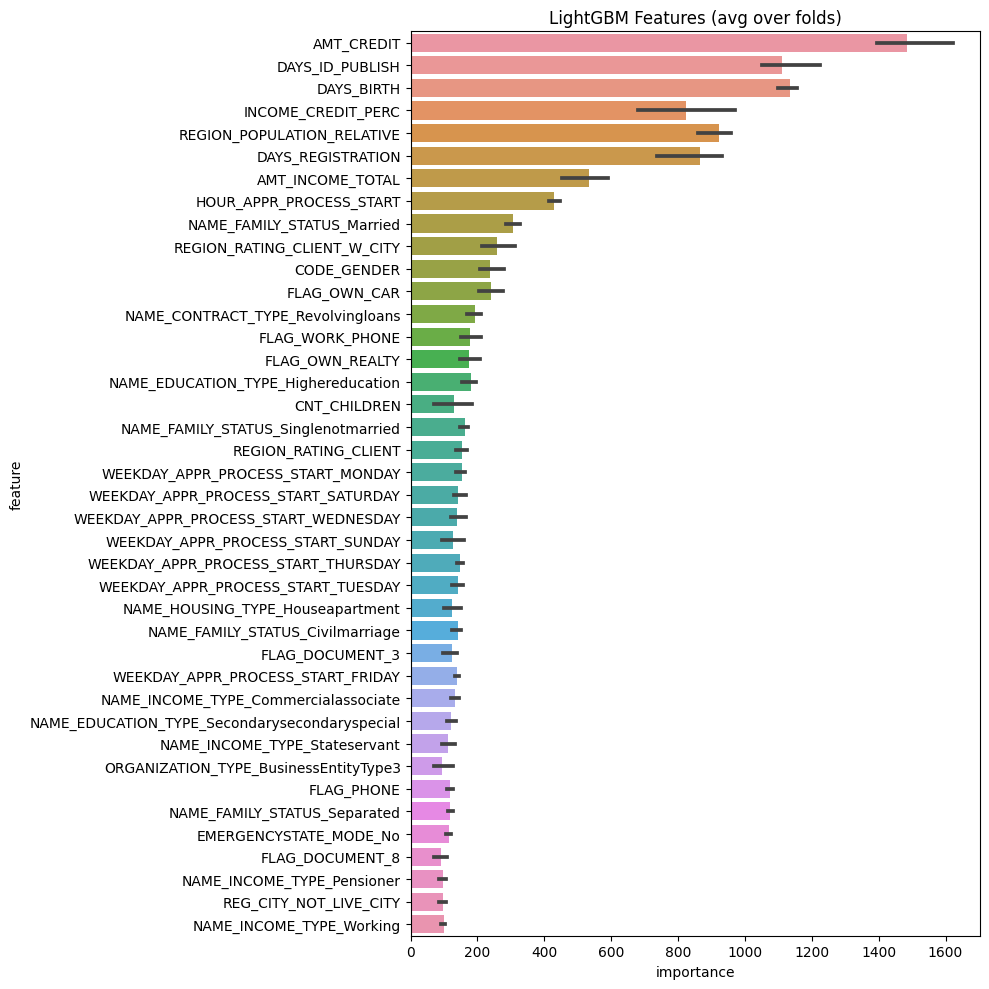

In [29]:
from mlflow.tracking import MlflowClient
name="LightGBM with SMOTE and RUS"
description="LightGBM model trained with SMOTE and RandomUnderSampler, using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=description
    )

# class_weight lightgbm

In [6]:
weight=282682/24825
df['TARGET'].value_counts()
weight

11.386988922457201

In [6]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {'class_weight':True,
        # 'scale_pos_weight':weight,
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.170163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99491
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080072 -> initscore=-2.441374
[LightGBM] [Info] Start training from score -2.441374
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.737916	training's binary_logloss: 0.27451	valid_1's auc: 0.726255	valid_1's binary_logloss: 0.279028


2024/11/12 16:02:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmr46lalh/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 16:02:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[LightGBM] [Info] Number of positive: 16697, number of negative: 188308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.374793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99763
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081447 -> initscore=-2.422850
[LightGBM] [Info] Start training from score -2.422850
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.736382	training's binary_logloss: 0.277963	valid_1's auc: 0.727863	valid_1's binary_logloss: 0.27375


2024/11/12 16:03:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpf_175ya7/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 16:03:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[LightGBM] [Info] Number of positive: 16538, number of negative: 188467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.358239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99627
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080671 -> initscore=-2.433262
[LightGBM] [Info] Start training from score -2.433262
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.738253	training's binary_logloss: 0.275958	valid_1's auc: 0.724251	valid_1's binary_logloss: 0.276777


2024/11/12 16:03:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp3k2hyxdt/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 16:03:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM with class_weight scale pos weight'.
2024/11/12 16:03:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM with class_weight scale pos weight, version 1
Created version '1' of model 'LightGBM with class_weight scale pos weight'.
2024/11/12 16:03:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM with class_weight scale pos weight at: http://127.0.0.1:5000/#/experimen

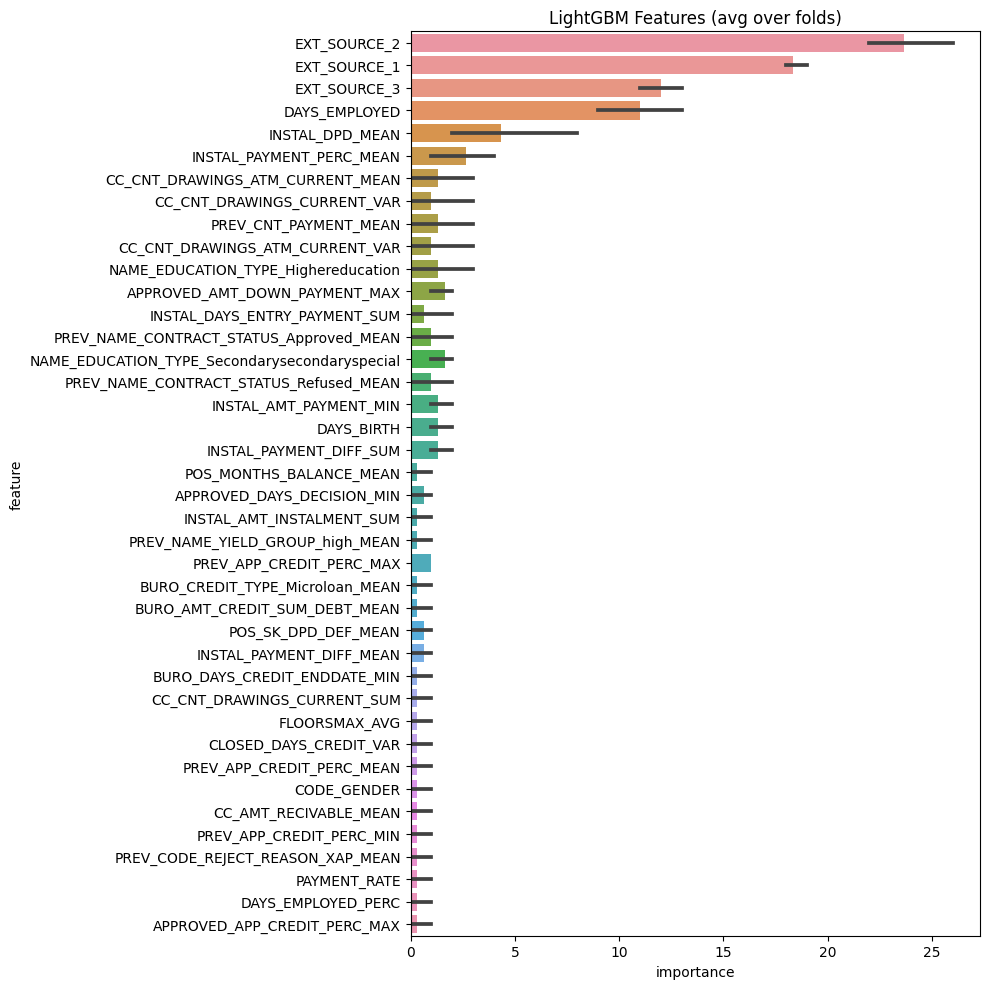

In [7]:
from mlflow.tracking import MlflowClient
name="LightGBM with class_weight scale pos weight"
descriptions="LightGBM model trained with class_weight scale pos weight, using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=descriptions
    )

# XGB 

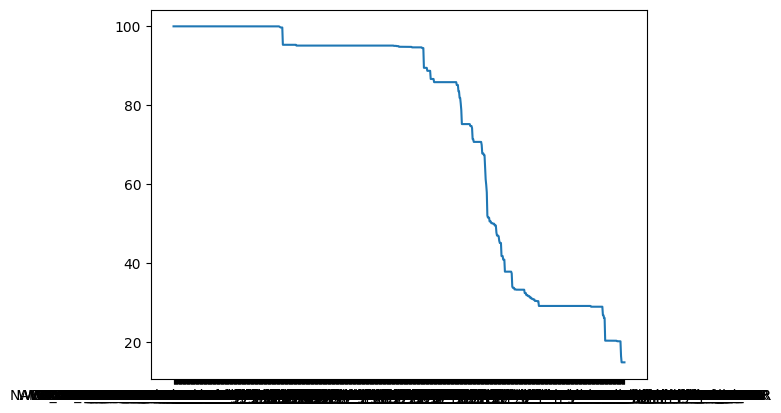

In [5]:
def data_completion_percentage(df, exclude_column='TARGET'):
    # Drop the specified column(s) from the dataframe if they exist
    df_excluded = df.drop(columns=[exclude_column], errors='ignore')
    # Calculate completion percentage for the remaining columns
    completion_percentage = df_excluded.notna().mean() * 100
    return completion_percentage # Sort for easier viewing

# Usage
completion_percentage = data_completion_percentage(df)
plt.plot(completion_percentage.sort_values(ascending=False) )

In [6]:
completion_percentage

index                               100.000000
SK_ID_CURR                          100.000000
CODE_GENDER                         100.000000
FLAG_OWN_CAR                        100.000000
FLAG_OWN_REALTY                     100.000000
                                       ...    
CC_NAME_CONTRACT_STATUS_nan_MAX      29.068831
CC_NAME_CONTRACT_STATUS_nan_MEAN     29.068831
CC_NAME_CONTRACT_STATUS_nan_SUM      29.068831
CC_NAME_CONTRACT_STATUS_nan_VAR      28.874586
CC_COUNT                             29.068831
Length: 797, dtype: float64

In [7]:
def filter_columns_by_completion(df, completion_percentage, threshold=80, exclude_column='TARGET'):
    # Keep 'TARGET' column if it exists, regardless of completion percentage
    columns_to_keep = completion_percentage.index[completion_percentage >= threshold].tolist()
    
    # Ensure 'TARGET' is always included if it's in the DataFrame
    if exclude_column in df.columns:
        columns_to_keep.append(exclude_column)
    
    # Remove duplicates in case 'TARGET' was already in the list
    columns_to_keep = list(set(columns_to_keep))
    
    # Filter the DataFrame to include only the selected columns
    df_cleaned = df[columns_to_keep]
    
    return df_cleaned

df_cleaned = filter_columns_by_completion(df, completion_percentage)

In [8]:
def fill_nans_with_median_except_target(df, target_column='TARGET'):
    # Select columns to fill (excluding the target column)
    columns_to_fill = df.columns[df.columns != target_column]
    
    # Fill NaN values with the median for all columns except the target
    df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].median())
    
    return df

# Usage
df_filled = fill_nans_with_median_except_target(df_cleaned)

In [14]:
import gc
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

def kfold_xgboost(df, num_folds):
    
    # Define parameters for XGBoost
    xgb_params = {'scale_pos_weight':weight,
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'max_depth': 8,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_child_weight': 39.3259775,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }

    # Log all parameters to MLflow
    for param, value in xgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    # Ensure no NaN or Inf values in the dataset
    train_df = train_df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    train_df = train_df.dropna()  # Drop rows with NaN (or fill them as appropriate)
    
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting XGBoost. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                early_stopping_rounds=3,
                verbose=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, ntree_limit=clf.best_ntree_limit)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], ntree_limit=clf.best_ntree_limit)[:, 1] / folds.n_splits

        # Collect feature importances
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.xgboost.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('xgb_importances01.png')


Starting XGBoost. Train shape: (307488, 509), test shape: (48744, 509)
Fold 1
[0]	validation_0-auc:0.74770	validation_1-auc:0.70478
[200]	validation_0-auc:0.87352	validation_1-auc:0.76990
[400]	validation_0-auc:0.90750	validation_1-auc:0.77764
[600]	validation_0-auc:0.92706	validation_1-auc:0.77995
[623]	validation_0-auc:0.92853	validation_1-auc:0.78001


2024/11/12 16:59:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp6pq8w6z_/model, flavor: xgboost). Fall back to return ['xgboost==1.6.2']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 16:59:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[0]	validation_0-auc:0.75250	validation_1-auc:0.70229
[200]	validation_0-auc:0.87166	validation_1-auc:0.76555
[400]	validation_0-auc:0.90474	validation_1-auc:0.77286
[543]	validation_0-auc:0.92024	validation_1-auc:0.77429


2024/11/12 17:27:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp3vsrbfui/model, flavor: xgboost). Fall back to return ['xgboost==1.6.2']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 17:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[0]	validation_0-auc:0.74756	validation_1-auc:0.70696
[200]	validation_0-auc:0.87019	validation_1-auc:0.77469
[400]	validation_0-auc:0.90176	validation_1-auc:0.78013
[410]	validation_0-auc:0.90301	validation_1-auc:0.78012


2024/11/12 17:47:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7i1oz7gn/model, flavor: xgboost). Fall back to return ['xgboost==1.6.2']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 17:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/12 17:47:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost with class_weight at: http://127.0.0.1:5000/#/experiments/0/runs/c7e76fa576e4498999acca1d8829b0fa.
2024/11/12 17:47:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


FileNotFoundError: [Errno 2] No such file or directory: 'xgb_importances01.png'

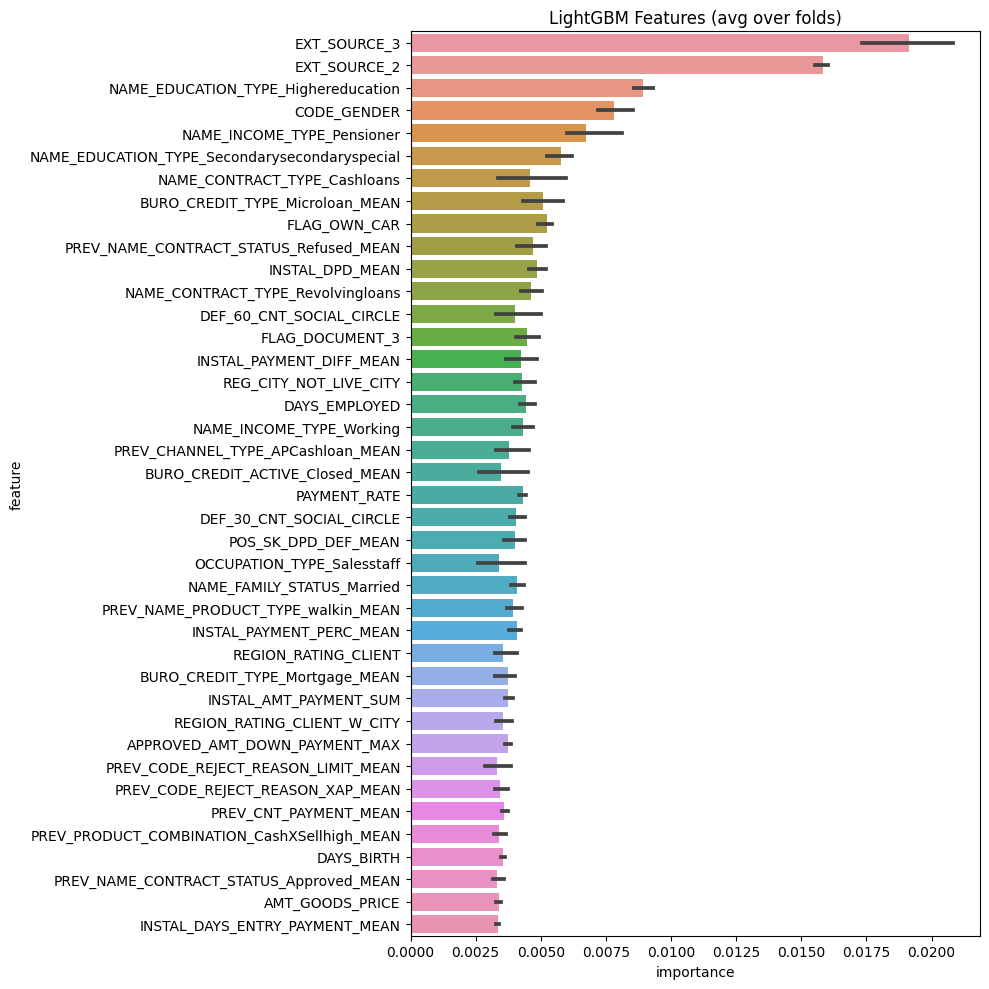

In [16]:
from mlflow.tracking import MlflowClient
name="XGBoost with class_weight"
description="XGBoost model trained with class_weight, using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "XGB_kfold_3")
    
    feat_importance = kfold_xgboost(df_filled, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=description
    )

# lgb with X_filled

In [19]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {'class_weight':'balanced',
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

Starting LightGBM. Train shape: (307507, 509), test shape: (48744, 509)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45280
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

2024/11/12 17:51:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5gxsf1f4/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 17:51:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[LightGBM] [Info] Number of positive: 16697, number of negative: 188308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45354
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024/11/12 17:53:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmptkwp67i5/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 17:53:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[LightGBM] [Info] Number of positive: 16538, number of negative: 188467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.520369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45271
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

2024/11/12 17:55:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_qhor6iq/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 17:55:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM with class_weight with x_filled'.
2024/11/12 17:55:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM with class_weight with x_filled, version 1
Created version '1' of model 'LightGBM with class_weight with x_filled'.
2024/11/12 17:55:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM with class_weight with x_filled at: http://127.0.0.1:5000/#/experiments/0/runs/3c

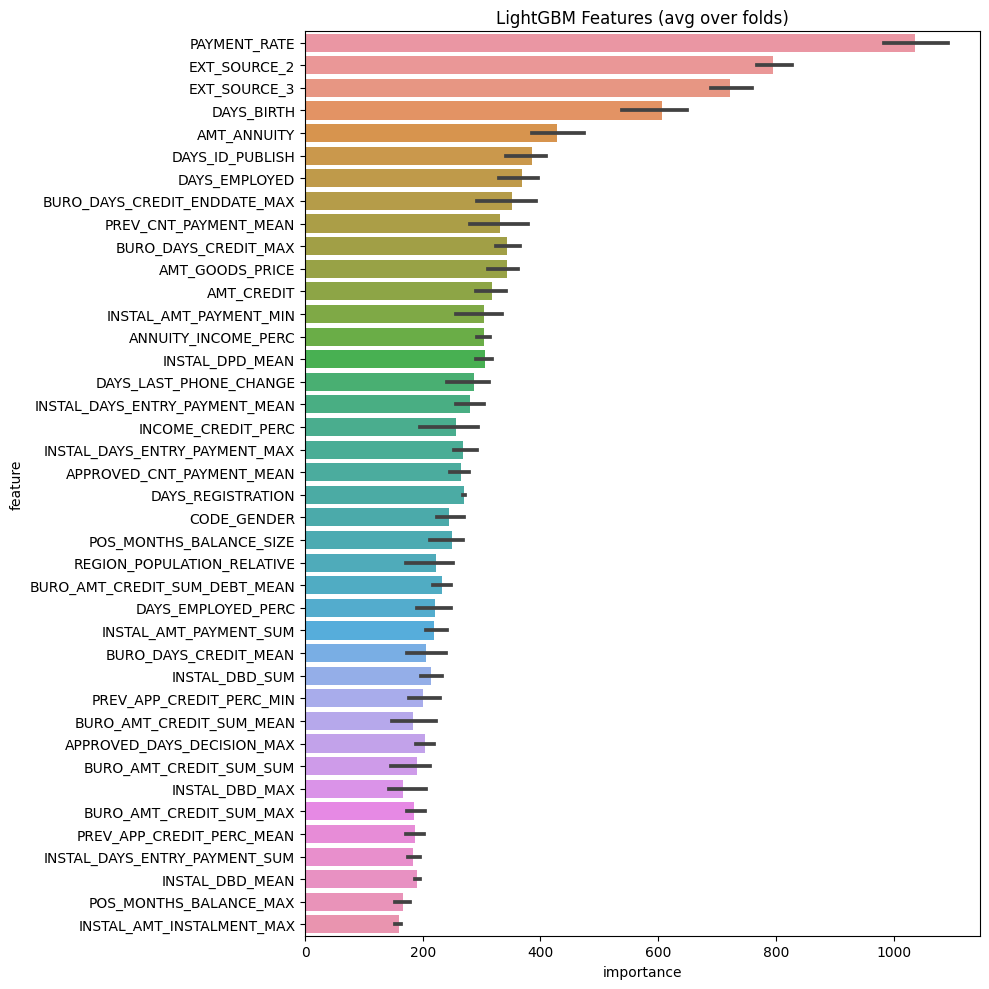

In [20]:
from mlflow.tracking import MlflowClient
name="LightGBM with class_weight with x_filled"
descriptions="LightGBM model trained with class_weight , using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df_filled, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=descriptions
    )

# lgb no weight

In [21]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

Starting LightGBM. Train shape: (307507, 509), test shape: (48744, 509)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45280
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080072 -> initscore=-2.441374
[LightGBM] [Info] Start training from score -2.441374
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

2024/11/12 18:04:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpko2ykare/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 18:04:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[LightGBM] [Info] Number of positive: 16697, number of negative: 188308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.516818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45354
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081447 -> initscore=-2.422850
[LightGBM] [Info] Start training from score -2.422850
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024/11/12 18:06:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8vkkoebl/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 18:06:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[LightGBM] [Info] Number of positive: 16538, number of negative: 188467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.601336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45271
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080671 -> initscore=-2.433262
[LightGBM] [Info] Start training from score -2.433262
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024/11/12 18:08:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpbigzyl6l/model, flavor: lightgbm). Fall back to return ['lightgbm==4.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/12 18:08:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM no with x_filled'.
2024/11/12 18:08:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM no with x_filled, version 1
Created version '1' of model 'LightGBM no with x_filled'.
2024/11/12 18:08:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM no with x_filled at: http://127.0.0.1:5000/#/experiments/0/runs/123710e4c6dc411ab6b2ad93df7db3ba.
2024/11/12 18:08:20 INFO mlf

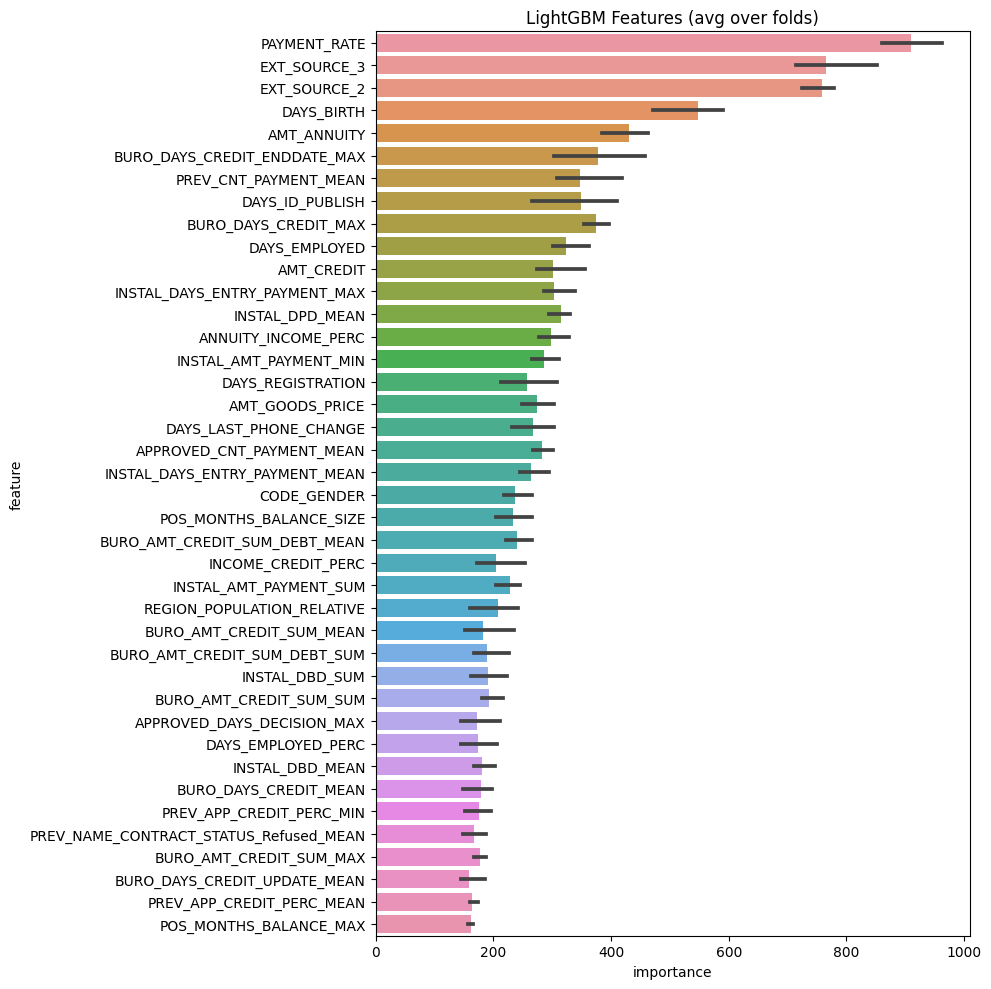

In [22]:
from mlflow.tracking import MlflowClient
name="LightGBM no with x_filled"
descriptions="LightGBM model trained , using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df_filled, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=descriptions
    )

# Model selected and method

## Grid search

In [3]:
df=pd.read_csv('data/df_filled.csv', index_col=0)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

In [4]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import mlflow
import gc
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
import pandas as pd


# Define your initial parameters
base_params = {
    'class_weight': 'balanced',
    'nthread': 4,
    'num_leaves': 34,
    'colsample_bytree': 0.9497036,
    'subsample': 0.8715623,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775
}

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.02, 0.05],
    # 'n_estimators': [1000, 2000, 5000]
}    

# Split data into train and test
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print(f"Starting LightGBM with GridSearch. Train shape: {train_df.shape}, test shape: {test_df.shape}")
df_sampled, _ = train_test_split(train_df, test_size=0.8, stratify=train_df['TARGET'], random_state=42)
print(f"Starting LightGBM with GridSearch. Sample shape: {df_sampled.shape}, test shape: {test_df.shape}")

feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    
# Initialize the LightGBM classifier
clf = LGBMClassifier(**base_params)

# Define the grid search
grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='roc_auc', verbose=1, n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(df_sampled[feats], df_sampled['TARGET'])

print(f"Best score found: {grid_search.best_score_}")
print(f"Best parameters found: {grid_search.best_params_}")


Starting LightGBM with GridSearch. Train shape: (307507, 510), test shape: (48744, 510)
Starting LightGBM with GridSearch. Sample shape: (61501, 510), test shape: (48744, 510)
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 2483, number of negative: 28268
[LightGBM] [Info] Number of positive: 2482, number of negative: 28268
[LightGBM] [Info] Number of positive: 2483, number of negative: 28268
[LightGBM] [Info] Number of positive: 2482, number of negative: 28268
[LightGBM] [Info] Number of positive: 2482, number of negative: 28268
[LightGBM] [Info] Number of positive: 2482, number of negative: 28268
[LightGBM] [Info] Number of positive: 2483, number of negative: 28268
[LightGBM] [Info] Number of positive: 2483, number of negative: 28268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.403015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

# Save the model

use model for API and next with drift and so on

In [7]:
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
train_x, train_y = train_df[feats], train_df['TARGET']
test_x, test_y = test_df[feats], test_df['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Train LightGBM with training data
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_error",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    'learning_rate': 0.05, 
    'max_depth': 8
}

model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=100)

# Evaluate on validation set
y_pred = (model.predict(X_valid) > 0.5).astype(int)
print("Accuracy on validation set:", accuracy_score(y_valid, y_pred))

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.313475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45558
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080502 -> initscore=-2.435540
[LightGBM] [Info] Start training from score -2.435540
Accuracy on validation set: 0.9188156482716009


In [ ]:
mlflow.register_model("runs:/<run_id>/model", "model_final")

In [8]:
name="LightGBM_final"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
with mlflow.start_run(run_name=name):

    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "final")
    mlflow.lightgbm.log_model(model, "lightgbm_model_final")
    mlflow.log_metric("accuracy", accuracy_score(y_valid, y_pred))
    print(f"Modèle enregistré dans MLflow avec ID de run: {mlflow.active_run().info.run_id}")
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"


2024/12/02 21:41:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle enregistré dans MLflow avec ID de run: 7006d3afef4a432dbf92ba2f6afc56bd
🏃 View run LightGBM_final at: http://127.0.0.1:5000/#/experiments/0/runs/7006d3afef4a432dbf92ba2f6afc56bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
